# Reinforcement Learning in Gridworld Environment

In this lab, you will implement the interaction of a reinforecment learning agent with its gridworld environment. You will find a description of the environment below, along with two pieces of relevant material from the lectures: the agent-environment interface and the Q-learning algorithm:

1. Simulate gridworld environment (Environment)

2. Create an agent that chooses actions randomly (`RandomAgent`)

3. Create an agent that uses Deterministic Q-learning (`QLearningAgent`). You can use initial Q values of 0, a stochasticity parameter for the $\epsilon$-greedy policy function $\epsilon=0.05$ where $0 \leq \epsilon \leq 1$. But feel free to experiment with other settings of these parameters.

4. Plot the average discounted cumulative rewards by the two agents through the episodes. This is called a **learning curve**. Run enough episodes for the Q-learning agents to converge to a near-optimal policy. 


## The Agent-Environment Interface

<img src="img/rl-agent.png" style="width: 400px;" align="left"/> 

<br><br><br>

The interaction of the agent with its environment starts at $t=0$ with the observation of the current state $s_0$. The agent then chooses an action $a_{0}$ to execute at $t=0$. The environment responds by changing its state to $s_1$ and returning the immediate reward signal $r_0$. 


## The Deterministic Gridworld Environment

<img src="img/gridworld.png" style="width: 700px;" align="right"/>

The agent has four possible actions in each state (grid square): UP ($\uparrow$), DOWN ($\downarrow$), LEFT ($\leftarrow$), and RIGHT ($\rightarrow$). If the direction of movement is blocked (at the borders), the agent remains in the same grid square. The initial state of the agent is one of the grid squares selected randomly which are not with gold or bomb. The grid squares with the gold and the bomb are **terminal states**. If the agent finds itself in one of these states (or squares), the episode ends. Then a new episode begins with the agent at the initial state.



You will use a reinforcement learning algorithm to compute the best policy for finding the gold with as few steps as possible (use $\gamma = 1$) while avoiding the bomb. For this, you will use the following reward function: $-1$ for each navigation action which deosn't end up at a terminal state, an additional $+100$ for finding the gold, and an additional $-100$ for hitting the bomb.

## Q-Learning for Deterministic Worlds
- For each $s,a$ initialize table entry $\hat{Q}(s,a) \leftarrow 0$
- Observe current state $s$
- Do forever:
    - Select an action $a$ ($\epsilon$-greedily) and execute it
    - Receive immediate reward $r$
    - Observe the new state $s^{\prime}$
    - Update the table entry for $\hat{Q}(s,a)$ as follows: $\hat{Q}(s,a) \leftarrow r + \gamma \max_{a^{\prime}} \hat{Q}(s^{\prime},a^{\prime})$
    - $s \leftarrow s^{\prime}$

## The `Environment` Class

- The `Environment` class implements the grid world environment:
    - The dimensions of the gridworld environment are defined by `height` and `width`
    - The immediate rewards for arriving each state are stored in `rewards` array

In [1]:
import matplotlib.pyplot as pl
import numpy as np
from IPython.display import clear_output as cls
%matplotlib inline

In [2]:
class Environment:
    def __init__(self, height=3, width=5, 
                 bomb_states=[(1,1),(0,2),(1,2)], bomb_reward=-10, 
                 gold_states=[(0,1)], gold_reward=10,
                 nonterminal_reward=-1, seed=7):
        """
        Initialises the grid world environemnt.
        """
        self.seed = seed
        self.rnd = np.random.RandomState()
        self.rnd.seed(self.seed)
        
        # setting up the grid world
        self.height = height
        self.width  = width
        self.set_rewards(bomb_states, bomb_reward, gold_states, gold_reward, nonterminal_reward)
        
    def reset_rnd(self):
        """
        Resets the random number generator.
        """
        self.rnd.seed(self.seed)
    
    def agent_start_state(self):
        """
        Returns a random start state for the agent taking actions in the gridworld to reach its goal (gold).
        """
        state = self.random_start_states[self.rnd.choice(range(len(self.random_start_states)))]
        return state
        
        
    def set_rewards(self, bomb_states, bomb_reward, gold_states, gold_reward, nonterminal_reward):
        """
        Prepares the grid world.
        """
        self.bomb_states = bomb_states.copy()
        self.gold_states = gold_states.copy()
        self.bomb_reward = bomb_reward
        self.gold_reward = gold_reward
        self.nonterminal_reward = nonterminal_reward
        
        self.rewards = np.ones((self.height, self.width)) * self.nonterminal_reward
        self.terminal_states = []
        for bomb_state in self.bomb_states:
            self.terminal_states.append(bomb_state)
            # set grid rewards for bomb states
            self.rewards[bomb_state[0], bomb_state[1]] = self.bomb_reward
            
        for gold_state in self.gold_states:
            self.terminal_states.append(gold_state)
            # set grid rewards for gold states
            self.rewards[gold_state[0], gold_state[1]] = self.gold_reward
            
            
        self.states = []
        for y in range(self.height):
            for x in range(self.width):
                self.states.append((y,x))
        
        self.random_start_states = [item for item in self.states if item not in self.terminal_states]
    
    def delta(self, state, action):
        """
        Returns the  "immediate reward" and "new state" of the agent resulting from applying "action" on "state".
        If the agent is at any border of the gridworld and takes action passing resulting in out of borders state,
        then the stays still but takes a negative reward equivalent to hitting a bomb.
        """
        # move UP
        if action == 'UP':
            # if the agent is at the top border, stays still, collects negative reward
            if state[0] != 0:
                new_state = ((state[0]-1), state[1])
                immediate_reward = self.rewards[new_state[0],new_state[1]]
            else:
                new_state = state
                immediate_reward = self.bomb_reward
                
        # move DOWN
        elif action == 'DOWN':
            # if the agent is at the bottom border, stays still, collects negative reward
            if state[0] != (self.height-1):
                new_state = ((state[0]+1), state[1])
                immediate_reward = self.rewards[new_state[0],new_state[1]]
            else:
                new_state = state
                immediate_reward = self.bomb_reward
                
        # move LEFT
        elif action == 'LEFT':
            # if the agent is at the left border, stays still, collects negative reward
            if state[1] != 0:
                new_state = (state[0], (state[1]-1))
                immediate_reward = self.rewards[new_state[0],new_state[1]]
            else:
                new_state = state
                immediate_reward = self.bomb_reward

        # move RIGHT
        elif action == 'RIGHT':
            # of the agent is at the right border, stay still, collect negative reward
            if state[1] != self.width - 1:
                new_state = (state[0], (state[1]+1))
                immediate_reward = self.rewards[new_state[0],new_state[1]]
            else:
                new_state = state
                immediate_reward = self.bomb_reward

        return new_state, immediate_reward
    
    def is_terminal_state(self, state):
        """
        Checks if the state is a terminal state (gold or bomb) and returns True for a 'TERMINAL' state, 
        otherwise returns False for a 'NONTERMINAL'
        """
        if state in self.terminal_states:
            return True
        else:
            return False
        
    def episode(self, agent, start_state, max_steps):
        """
        Runs a single episode which terminates when the "agent" starting at the "start_state" in 
        the gridworld reaches a terminal state. Each episode runs maximum of "max_steps" steps.
        """
        step = 0 # keeps track of how many steps the agent has taken
        agent.start(start_state, agent.learning_mode) # starts the agent at start_state
        state = start_state
        while (step < max_steps) and (not self.is_terminal_state(state)):
            # the agent takes an action on the state according to its policy
            action = agent.policy(state)
            # the environment changes the state of the agent (to next_state) and returns a reward
            next_state, reward = self.delta(state, action)
            # the agent observes the new state (next_state) and makes necessary updates
            agent.update(state, action, reward, next_state)
            # loop continues until either max_steps are taken by the agent or the agent reaches a terminal state
            step = step + 1
            state = next_state
        
    
    def simulation(self, agent, max_episodes=1000, max_steps=50):
        """
        Simulates agent-environment interaction for "max_episodes" episodes. Each episode runs 
        maximum of "max_steps" steps. This function returns cumulative reward the agent achieves per episode. 
        """
        cumulative_reward_simulation = [] # initialise performance log
        episode = 0
        while episode < max_episodes:
            start_state = self.agent_start_state()
            self.episode(agent, start_state, max_steps)
            cumulative_reward_simulation.append(agent.cumulative_reward)
            episode = episode + 1
            
        return cumulative_reward_simulation
    
    def show(self, color=(0,0,0), dpi=300, fontsize=6, fig_save_file='img/gridworld.png'):
        """
        Shows the gridworld environment, actions and rewards.
        """
        cls(wait=True)
        fig, ax = pl.subplots(dpi=300)
        fig.set_tight_layout(True)
        ax.invert_yaxis()
        ax.set_aspect('equal')
        if self.height > self.width:
            y_min, y_max = 0.0, 1.0
            y_range = np.linspace(y_min, y_max, (self.height+1))
            x_range = y_range[0:self.width+1]
            x_min, x_max = np.min(x_range), np.max(x_range)
        elif self.height < self.width:
            x_min, x_max = 0.0, 1.0
            x_range = np.linspace(x_min, x_max, (self.width+1))
            y_range = x_range[0:self.height+1]
            y_min, y_max = np.min(y_range), np.max(y_range)
        else:
            y_min, y_max = 0.0, 1.0
            x_min, x_max = 0.0, 1.0
            y_range = np.linspace(y_min, y_max, (self.height+1))
            x_range = np.linspace(x_min, x_max, (self.width+1))
        
        for y in y_range:
            line_x = [x_min, x_max]
            line_y = [y, y]
            ax.plot(line_x, line_y,'-', color=(0,0,0), linewidth=1)
        
        for x in x_range:
            line_x = [x, x]
            line_y = [y_min, y_max]
            ax.plot(line_x, line_y, '-', color=(0,0,0), linewidth=1)
        
        for i in range(y_range.size - 1):
            for j in range(x_range.size - 1):
                state = (i, j)
                x, y = ((x_range[j]+x_range[j+1])/2.0), ((y_range[i]+y_range[i+1])/2.0)
                if state in self.terminal_states:
                    if state in self.gold_states:
                        ax.text(x, y, 'GOLD', ha='center', va='center', fontsize=fontsize, fontweight='bold')
                    else:
                        ax.text(x, y, 'BOMB', ha='center', va='center', fontsize=fontsize, fontweight='bold')
                else:
                    dx, dy = (x_range[j+1]-x_range[j]), ((y_range[i+1]-y_range[i]))
                    g_dx = 0.05 * dx
                    g_dy = 0.05 * dy
                    a_dx = 0.20 * dx
                    a_dy = 0.20 * dy
                    
                    new_state, reward = self.delta(state, 'RIGHT')
                    reward_text = '{:.0f}'.format(reward)
                    ax.arrow(x, y, a_dx, 0, color=color, linewidth=0.5) # right arrow
                    ax.text(x+a_dx+g_dx, y, reward_text, 
                            ha='left', va='center', fontsize=fontsize, rotation=270)
                    
                    new_state, reward = self.delta(state, 'LEFT')
                    reward_text = '{:.0f}'.format(reward)
                    ax.arrow(x, y, -a_dx, 0, color=color, linewidth=0.5) # left arrow
                    ax.text(x-a_dx-g_dx, y, reward_text, 
                            ha='right', va='center', fontsize=fontsize, rotation=270)
                    
                    new_state, reward = self.delta(state, 'UP')
                    reward_text = '{:.0f}'.format(reward)
                    ax.arrow(x, y, 0, -a_dy, color=color, linewidth=0.5) # up arrow
                    ax.text(x, y-a_dy-g_dy, reward_text, 
                            ha='center', va='bottom', fontsize=fontsize)
                    
                    new_state, reward = self.delta(state, 'DOWN')
                    reward_text = '{:.0f}'.format(reward)
                    ax.arrow(x, y, 0, a_dy, color=color, linewidth=0.5) # down arrow
                    ax.text(x, y+a_dy+g_dy, reward_text, 
                            ha='center', va='top', fontsize=fontsize)
        ax.axis(False)
        ax.set_title('Gridworld Environment, Actions and Rewards', fontsize=8)
        pl.tight_layout(pad=0.0)
        if fig_save_file is not None:
            pl.savefig(fig_save_file)

## The `BaseAgent` Class

- The `BaseAgent` class implements base agent class which interacts with the Gridworld Environment.

In [3]:
class BaseAgent:
    def __init__(self, state=None, gamma=1.0, learning_mode=True, seed=7, agent_name='Base Agent'):
        """
        Initialises the base agent class.
        """
        self.rnd = np.random.RandomState()
        self.seed = seed
        self.rnd.seed(self.seed)
        # these are the actions that our agents are capable of in the gridworld environment
        self.actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']
        # the base agent doesn't know where it starts on the gridworld environemnt
        self.state = state
        self.gamma = gamma
        self.learning_mode = learning_mode
        self.discount_factor = 1.0
        self.cumulative_reward = 0.0
        self.agent_name = agent_name
    
    def start(self, state, learning_mode):
        """
        Starts the base agent. 
        """
        self.state = state
        self.learning_mode = learning_mode
        self.discount_factor = 1.0
        self.cumulative_reward = 0.0
        
    def reset_rnd(self):
        """
        Resets the random number generator of the base agent.
        """
        self.rnd.seed(self.seed)
        
        
    def policy(self, state):
        """
        Policy of the base agent which will be overloaded by other agents.
        """
        pass
    
    def update(self, state, action, reward, new_state):
        """
        Updates the state of the agent and keeps track of cumulative reward. 
        This function will be overloaded by other agents.
        """
        pass
        

## The `RandomAgent` Class

- The `RandomAgent` class implements a random agent which makes random moves at each state of the gridworld environment.

In [4]:
class RandomAgent(BaseAgent):
    def __init__(self, state=None, gamma=1.0, 
                 learning_mode=True, seed=7, 
                 agent_name='Random Agent'):
        super(RandomAgent, self).__init__(state, gamma, 
                                          learning_mode, seed, agent_name) # this initilises the base agent
        
    def start(self, state, learning_mode):
        super(RandomAgent, self).start(state, learning_mode)
    
    def policy(self, state=None):
        """
        Returns a random action as this agent takes random actions at each state.
        """
        self.state = state
        self.action = self.rnd.choice(self.actions)
        return self.action
    
    def update(self, state, action, reward, new_state):
        """
        Updates the agent's state and discounted cumulative reward.
        """
        self.cumulative_reward = self.cumulative_reward + self.discount_factor * reward
        self.discount_factor = self.discount_factor * self.gamma
        self.state = new_state

## The `QLearningAgent` Class

- The `QLearningAgent` class implements the Deterministic Q-Learning Agent.

In [5]:
class QLearningAgent(BaseAgent):
    def __init__(self, state=None, gamma=1.0, 
                 learning_mode=True, epsilon=0.05, 
                 seed=7, agent_name='Q-Learning Agent'):
        """
        Initialises the Q-Learning Agent
        """
        super(QLearningAgent, self).__init__(state, gamma, 
                                             learning_mode, seed, agent_name) # this initilises the base agent
        self.Q = dict() # Q-table which is initially empty
        self.epsilon = epsilon
     
    def start(self, state, learning_mode):
        super(QLearningAgent, self).start(state, learning_mode)
        
        
    def policy(self, state, single_action=True):
        """
        Returns an action from the Q-table for the input "state". If multiple optimal actions exist, 
        makes a random choice during learning mode othewise returns all possible actions. 
        If the input state does not exist in Q-table, creates the corresponding entries in the Q-table and 
        zeroes the corresponding (state, action) entries. It will take an exploratory random action 
        dependent on epsilon.
        """
        # if state doesn't exist in our Q-table, create and zero the corresponding (state, action) entries
        if state not in self.Q.keys():
            self.Q[state] = dict()
            for action in self.actions:
                self.Q[state][action] = 0.0
        if self.learning_mode and (self.rnd.uniform(0,1) < self.epsilon):
            action = self.rnd.choice(self.actions)
        else:
            value = max(self.Q[state].values())
            actions = [a for a, v in self.Q[state].items() if v == value]
            if single_action:
                action  = self.rnd.choice(actions)
            else:
                action = actions
        self.state = state
        self.action = action
        
        return action
    
    def update(self, state, action, reward, new_state):
        """
        Updates the agent's state and discounted cumulative reward. It also updates the Q-values 
        using Q-learning during the agent is in learning mode.
        """
        if new_state not in self.Q.keys():
            self.Q[new_state] = dict()
            for action in self.actions:
                self.Q[new_state][action] = 0.0
        if self.learning_mode:
            self.Q[state][action] = reward + self.gamma * max(self.Q[new_state].values())
            
        self.cumulative_reward = self.cumulative_reward + self.discount_factor * reward
        self.discount_factor = self.discount_factor * self.gamma
        self.state = new_state
        
    def print_Q_table(self):
        """
        Prints the Q-table.
        """ 
        lf = '|{:^10s}|{:^10.2f}|{:^10.2f}|{:^10.2f}|{:^10.2f}|'
        hf1 = '|{:^10s}|{:^43s}|'
        hf2 = '|{:^10s}|{:^10s}|{:^10s}|{:^10s}|{:^10s}|'
        ls = '='*56
        print(ls)
        print(hf1.format('State', 'Actions'))
        print(hf2.format('','LEFT', 'RIGHT', 'UP', 'DOWN'))
        print(ls)
        for s in self.Q.keys():
            state = '({:d},{:d})'.format(s[0],s[1])
            print(lf.format(state, self.Q[s]['LEFT'], self.Q[s]['RIGHT'], self.Q[s]['UP'], self.Q[s]['DOWN']))
        print(ls)
    
    
    def show(self, env, what='Q-Table', 
             color=(0,0,0), dpi=300, 
             fontsize=6, fig_save_file=None):
        """
        Shows Q-table, optimal policy and the agent's actions on the gridworld.
        """
        cls(wait=True)
        fig, ax = pl.subplots(dpi=300)
        fig.set_tight_layout(True)
        ax.invert_yaxis()
        ax.set_aspect('equal')
        if env.height > env.width:
            y_min, y_max = 0.0, 1.0
            y_range = np.linspace(y_min, y_max, (env.height+1))
            x_range = y_range[0:env.width+1]
            x_min, x_max = np.min(x_range), np.max(x_range)
        elif env.height < env.width:
            x_min, x_max = 0.0, 1.0
            x_range = np.linspace(x_min, x_max, (env.width+1))
            y_range = x_range[0:env.height+1]
            y_min, y_max = np.min(y_range), np.max(y_range)
        else:
            y_min, y_max = 0.0, 1.0
            x_min, x_max = 0.0, 1.0
            y_range = np.linspace(y_min, y_max, (env.height+1))
            x_range = np.linspace(x_min, x_max, (env.width+1))
        
        for y in y_range:
            line_x = [x_min, x_max]
            line_y = [y, y]
            ax.plot(line_x, line_y,'-', color=(0,0,0), linewidth=1)
        
        for x in x_range:
            line_x = [x, x]
            line_y = [y_min, y_max]
            ax.plot(line_x, line_y, '-', color=(0,0,0), linewidth=1)
        
        for i in range(y_range.size - 1):
            for j in range(x_range.size - 1):
                state = (i, j)
                x, y = ((x_range[j]+x_range[j+1])/2.0), ((y_range[i]+y_range[i+1])/2.0)
                if state in env.terminal_states:
                    if state in env.gold_states:
                        ax.text(x, y, 'GOLD', ha='center', va='center', fontsize=fontsize, fontweight='bold')
                    else:
                        ax.text(x, y, 'BOMB', ha='center', va='center', fontsize=fontsize, fontweight='bold')
                else:
                    if state not in self.Q.keys():
                        ax.text(x, y, 'NOT\nEXPLORED', ha='center', va='center', fontsize=fontsize, fontweight='bold')
                    else:
                        dx, dy = (x_range[j+1]-x_range[j]), ((y_range[i+1]-y_range[i]))
                        g_dx = 0.05 * dx
                        g_dy = 0.05 * dy
                        a_dx = 0.2 * dx
                        a_dy = 0.2 * dy
                        if what == 'Q-Table':
                            actions = self.Q[state].keys()
                        elif what == 'Optimal Policy':
                            actions = self.policy(state, single_action=False)
                        else:
                            actions = []
                        
                        for action in actions:
                            if action == 'RIGHT':
                                reward = self.Q[state]['RIGHT']
                                reward_text = '{:.1f}'.format(reward)
                                ax.arrow(x, y, a_dx, 0, color=color, linewidth=0.5) # right arrow
                                ax.text(x+a_dx+g_dx, y, reward_text, 
                                        ha='left', va='center', fontsize=fontsize, rotation=270)
                            
                            elif action == 'LEFT':
                                reward = self.Q[state]['LEFT']
                                reward_text = '{:.1f}'.format(reward)
                                ax.arrow(x, y, -a_dx, 0, color=color, linewidth=0.5) # left arrow
                                ax.text(x-a_dx-g_dx, y, reward_text,
                                        ha='right', va='center', fontsize=fontsize, rotation=270)
                            
                            elif action == 'UP':
                                reward = self.Q[state]['UP']
                                reward_text = '{:.1f}'.format(reward)
                                ax.arrow(x, y, 0, -a_dy, color=color, linewidth=0.5) # up arrow
                                ax.text(x, y-a_dy-g_dy, reward_text,
                                        ha='center', va='bottom', fontsize=fontsize)
                            
                            elif action == 'DOWN':
                                reward = self.Q[state]['DOWN']
                                reward_text = '{:.1f}'.format(reward)
                                ax.arrow(x, y, 0, a_dy, color=color, linewidth=0.5) # down arrow
                                ax.text(x, y+a_dy+g_dy, reward_text,
                                        ha='center', va='top', fontsize=fontsize)
        ax.axis(False)
        ax.set_title(what + ' of {:s} on the Gridworld Environment'.format(self.agent_name), fontsize=8)
        pl.tight_layout(pad=0.0)
        if fig_save_file is not None:
            pl.savefig(fig_save_file)

## Agent Learning Process

### Setup the Gridworld Environment

In [6]:
height = 5
width = 9
gold_states = [(0,0), (0,8), (4,0), (4,8), (2,4)]
gold_reward = 100
bomb_states = [(1,4), (3,4)]
bomb_reward = -100
nonterminal_reward = -1
env = Environment(height=height, width=width, 
                  gold_states=gold_states, gold_reward=gold_reward,
                  bomb_states=bomb_states, bomb_reward=bomb_reward,
                  nonterminal_reward=nonterminal_reward)

### Show the Gridworld Environment, Actions and Rewards

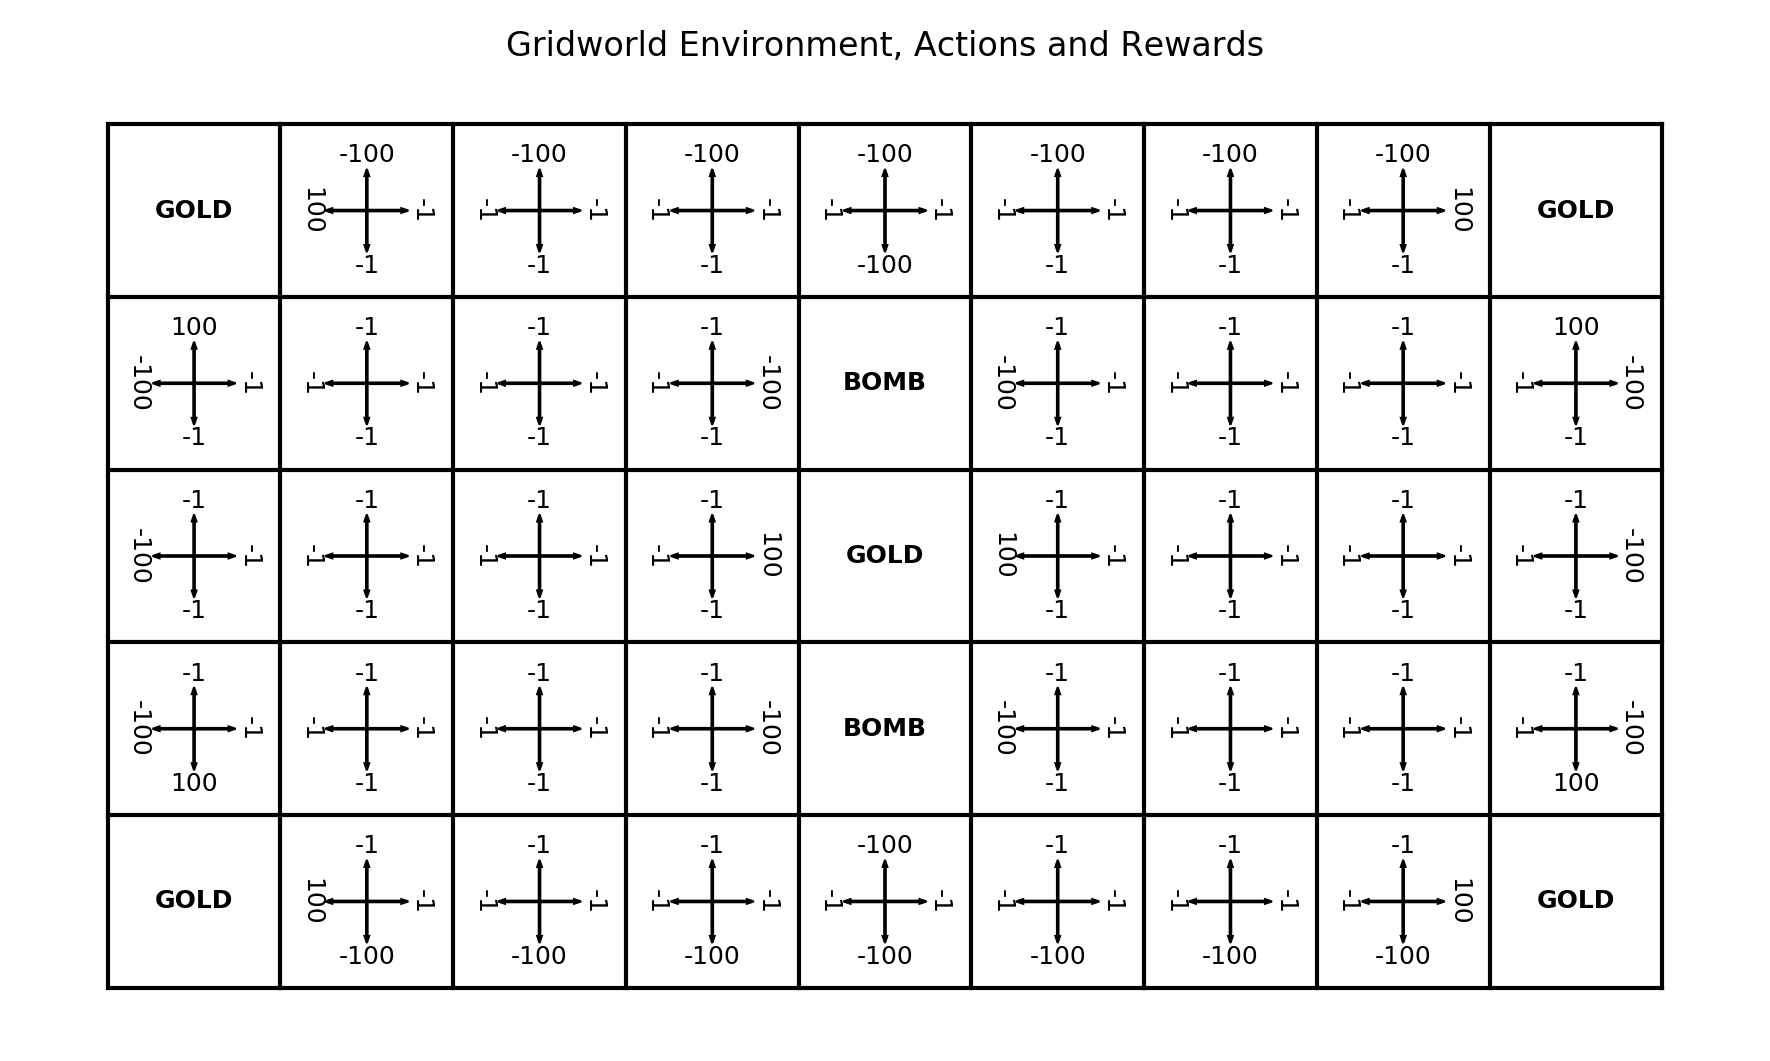

In [7]:
env.show()

### Agent-Environment Interactions for Learning Optimal Policy

In [8]:
epsilon = 0.05
gamma = 1.0
learning_mode = True
max_episodes = 10000
max_steps = 100

agent_random = RandomAgent(gamma=gamma, learning_mode=learning_mode)
env.reset_rnd()
cumulative_reward_random = env.simulation(agent_random, max_episodes=max_episodes, max_steps=max_steps)

agent_Q = QLearningAgent(gamma=gamma, learning_mode=learning_mode, epsilon=epsilon)
env.reset_rnd()
cumulative_reward_Q = env.simulation(agent_Q, max_episodes=max_episodes, max_steps=max_steps)
# after agent learns, set learning_mode of the agent to False
agent_Q.learning_mode = False

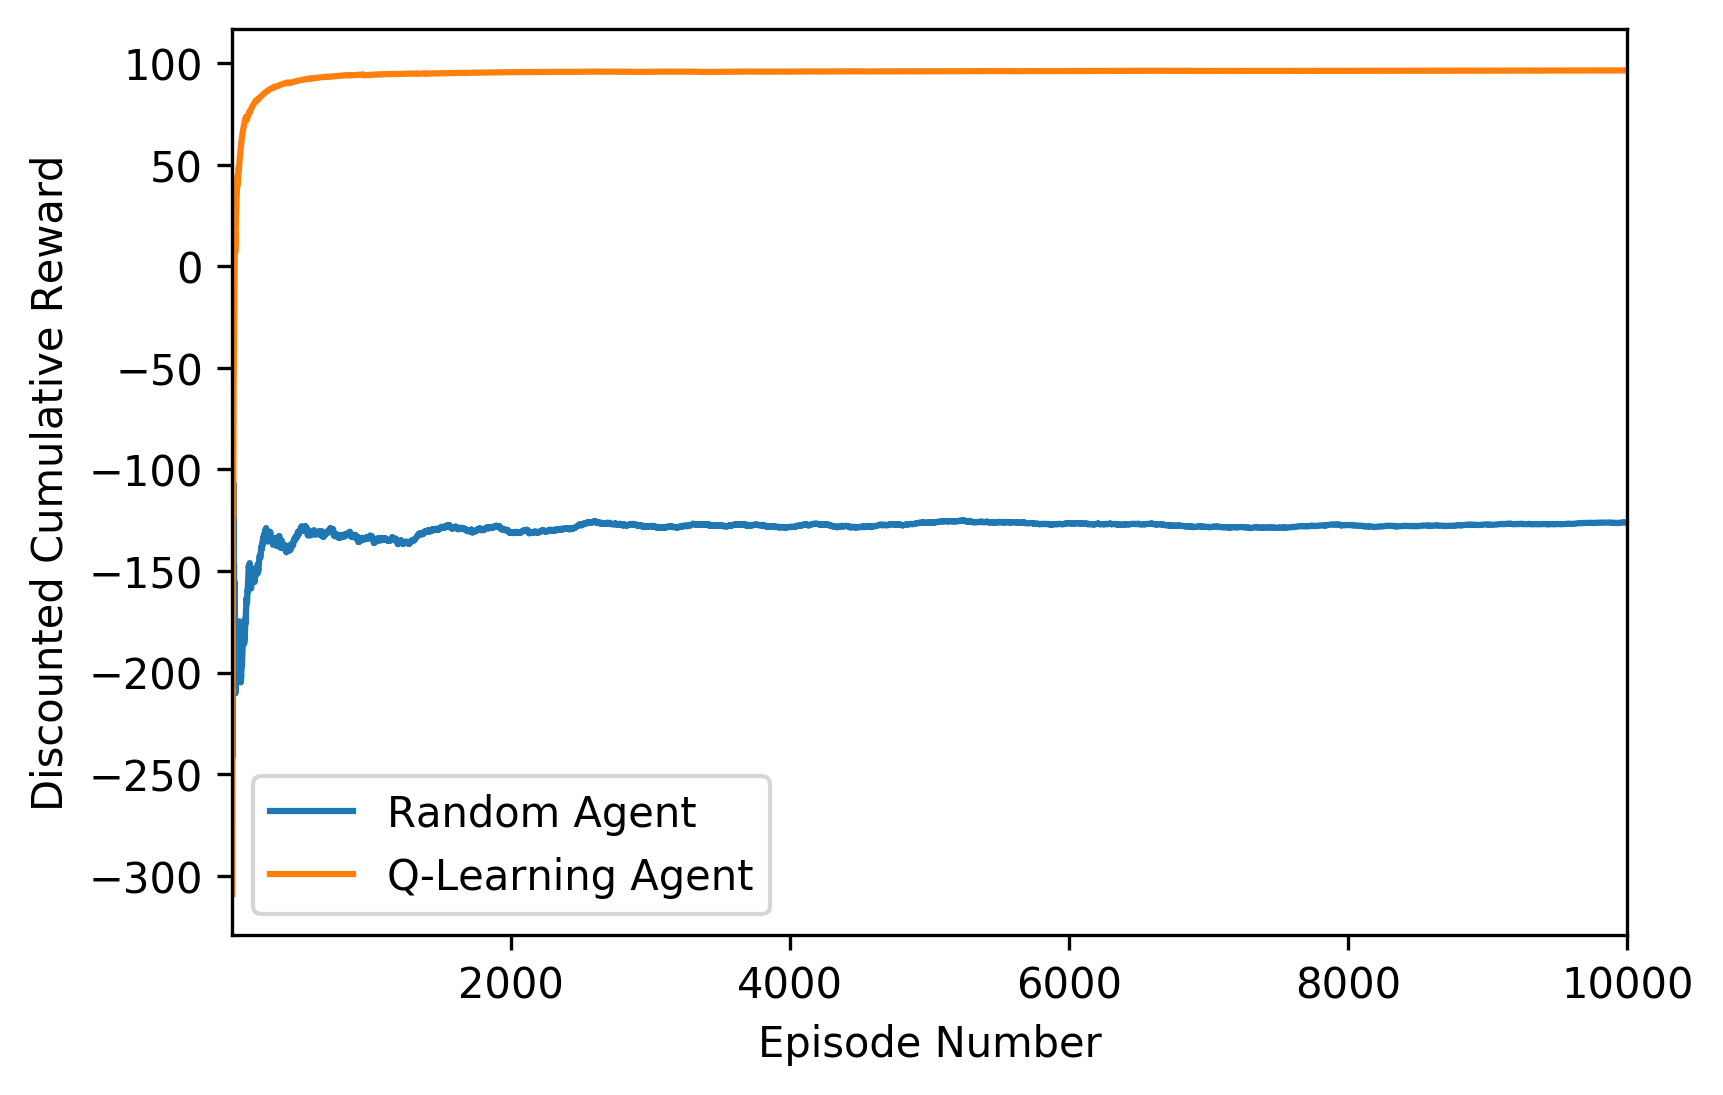

In [9]:
episode_range = np.arange(1, max_episodes+1)
cumulative_reward_Q = np.cumsum(cumulative_reward_Q)
cumulative_reward_Q = cumulative_reward_Q / episode_range

cumulative_reward_random = np.cumsum(cumulative_reward_random)
cumulative_reward_random = cumulative_reward_random / episode_range

pl.figure(dpi=300)
pl.plot(episode_range, cumulative_reward_random, label=agent_random.agent_name)
pl.plot(episode_range, cumulative_reward_Q, label='Q-Learning Agent')
pl.xlabel('Episode Number')
pl.ylabel('Discounted Cumulative Reward')
pl.xlim(min(episode_range), max(episode_range))
pl.legend();

What do you think about the effect of $\epsilon$ on Q-Learning?

### Q-values after Q-Learning

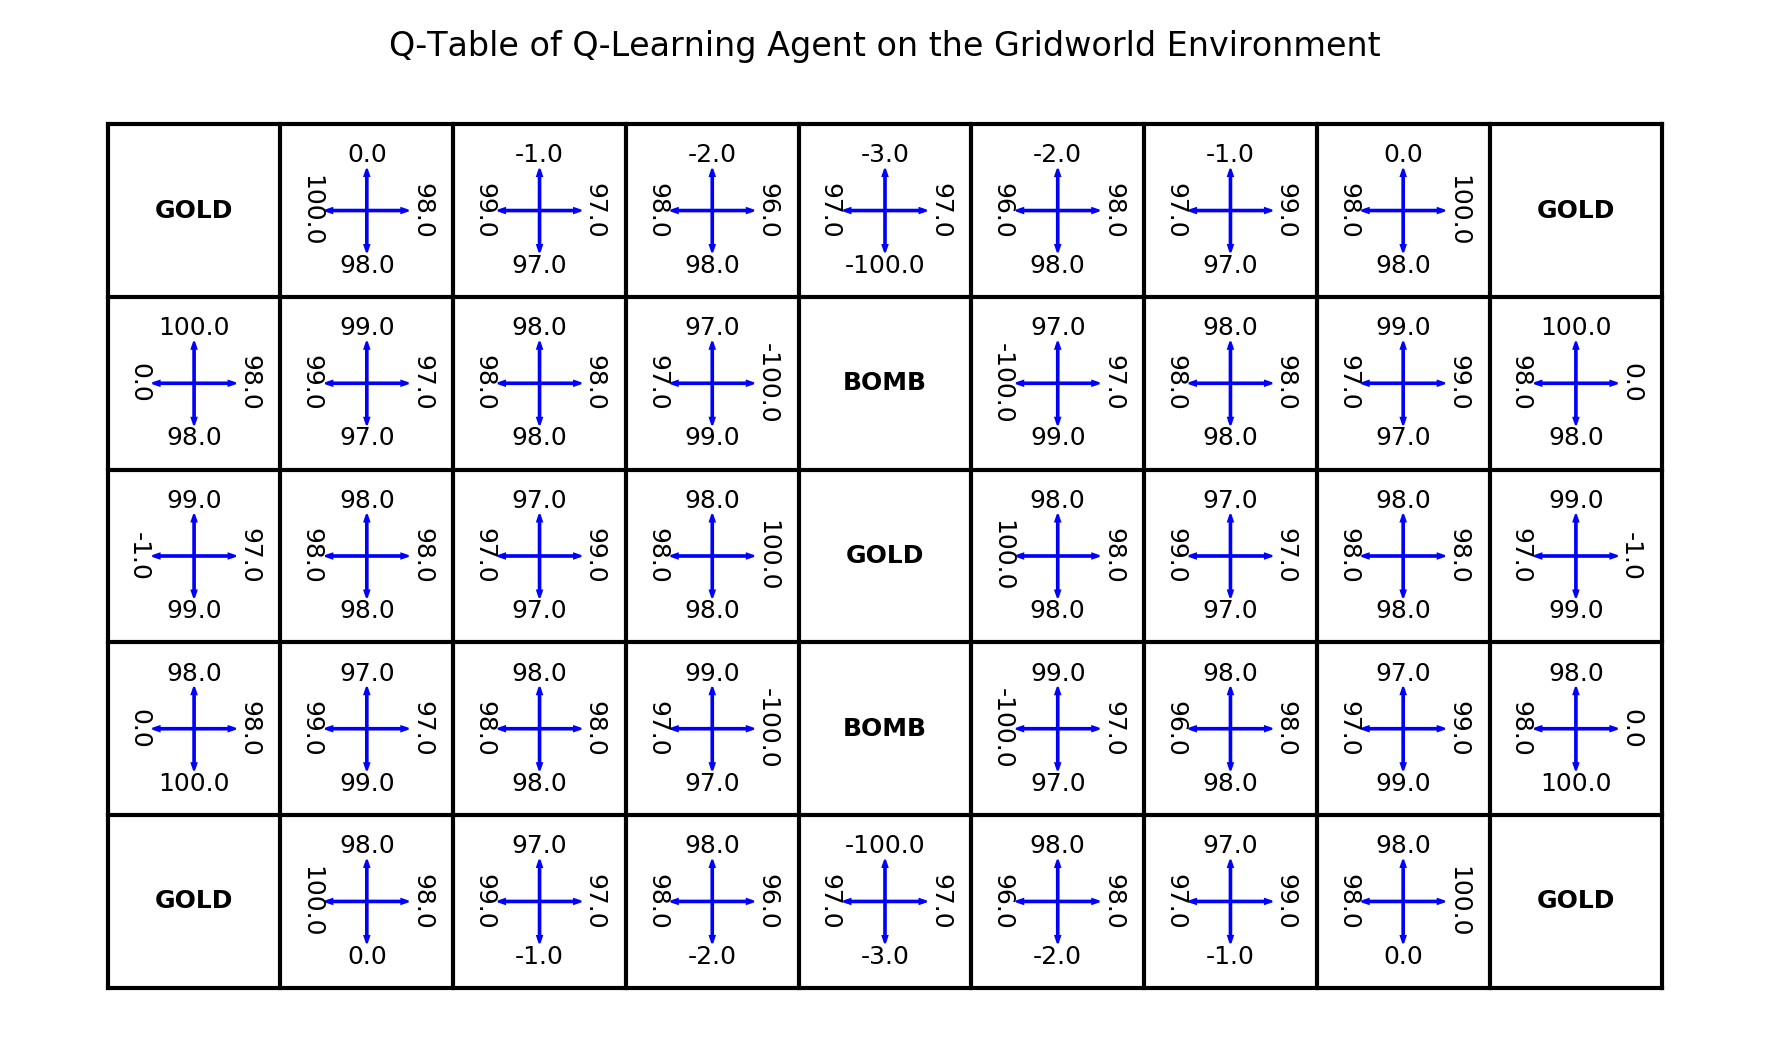

In [10]:
agent_Q.show(env, what='Q-Table',  color=(0,0,1))

In [11]:
agent_Q.print_Q_table()

|  State   |                  Actions                  |
|          |   LEFT   |  RIGHT   |    UP    |   DOWN   |
|  (0,5)   |  96.00   |  98.00   |  -2.00   |  98.00   |
|  (1,5)   | -100.00  |  97.00   |  97.00   |  99.00   |
|  (1,6)   |  98.00   |  98.00   |  98.00   |  98.00   |
|  (0,6)   |  97.00   |  99.00   |  -1.00   |  97.00   |
|  (0,7)   |  98.00   |  100.00  |   0.00   |  98.00   |
|  (0,4)   |  97.00   |  97.00   |  -3.00   | -100.00  |
|  (1,4)   |   0.00   |   0.00   |   0.00   |   0.00   |
|  (3,2)   |  98.00   |  98.00   |  98.00   |  98.00   |
|  (4,2)   |  99.00   |  97.00   |  97.00   |  -1.00   |
|  (3,1)   |  99.00   |  97.00   |  97.00   |  99.00   |
|  (4,1)   |  100.00  |  98.00   |  98.00   |   0.00   |
|  (4,0)   |   0.00   |   0.00   |   0.00   |   0.00   |
|  (0,3)   |  98.00   |  96.00   |  -2.00   |  98.00   |
|  (0,2)   |  99.00   |  97.00   |  -1.00   |  97.00   |
|  (1,2)   |  98.00   |  98.00   |  98.00   |  98.00   |
|  (0,1)   |  100.00  |  98.00 

### Optimal Policy after Q-Learning

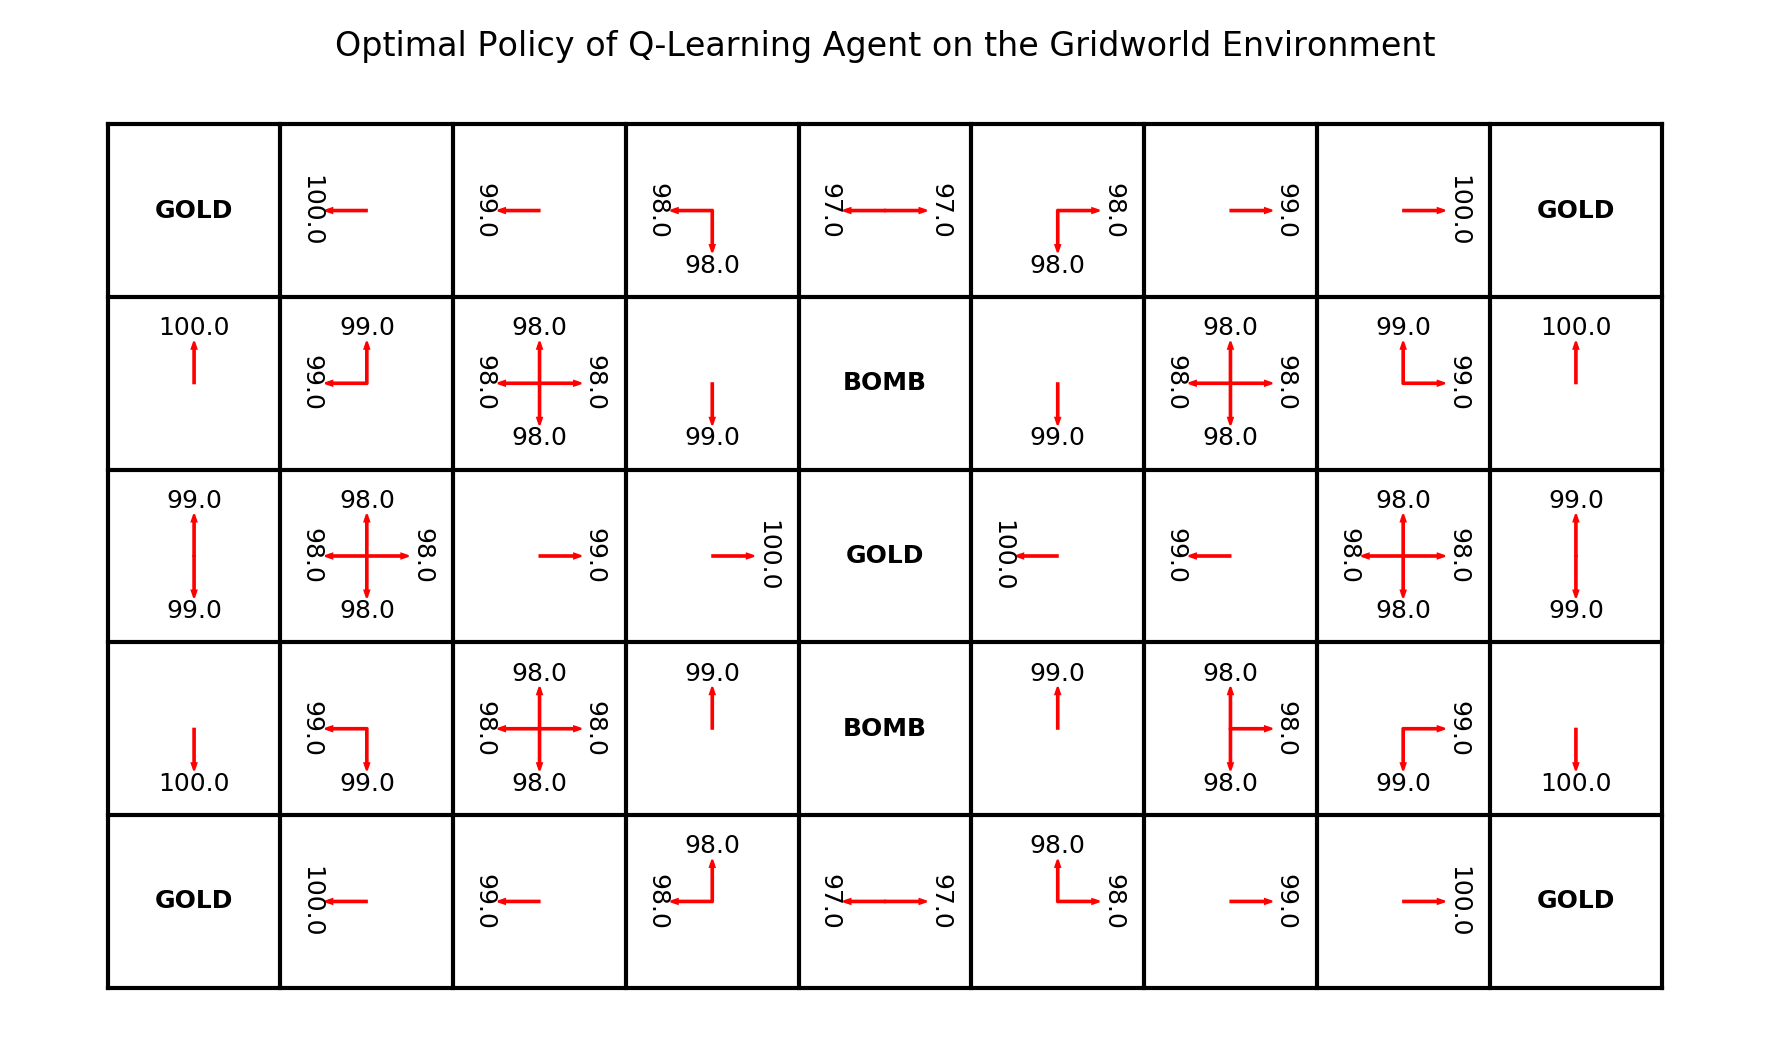

In [12]:
agent_Q.show(env, what='Optimal Policy',  color=(1,0,0))